In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
from typing import List, Tuple

import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dropout, Input, Dense, MaxPool1D, GlobalMaxPool1D
from tensorflow.keras.optimizers import schedules, Adam, SGD, Nadam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.activations import softmax
from tensorflow.keras.models import Model, load_model

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

from tools import balance_triplet_positions, combine_three_rows, verify_triplet_positives, class_report

import textwrap

2025-01-29 17:44:40.000995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738165483.316285   22319 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738165483.574940   22319 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 17:44:45.922770: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Balance the Data
>Aim to balance the data such that each position has an equal amount of recombinants; furthermore, shuffle the position of recombinants such that a certain position will have all the difficult examples.

In [5]:
#Check if the correct dataframe structures exist and that they've been balanced.
if not Path("dataParsed_Test/Train_triplet_balanced.csv").exists() and not Path("dataParsed_Test/Test_triplet_balanced.csv").exists() and not Path("dataParsed_Test/Unseen_triplet_balanced.csv").exists():
    #Balance the positions of the dataframe
    balanced_train = balance_triplet_positions(input_file="dataParsed_Test/Train.csv")
    balanced_test = balance_triplet_positions(input_file="dataParsed_Test/Test.csv")
    balanced_unseen = balance_triplet_positions(input_file="dataParsed_Test/Unseen.csv")

    #Combine each triplet into a single row
    X_train = combine_three_rows(input_file=balanced_train, output_file='dataParsed_Test/Train_triplet_balanced.csv')
    X_test = combine_three_rows(input_file=balanced_test, output_file='dataParsed_Test/Test_triplet_balanced.csv')
    X_unseen = combine_three_rows(input_file=balanced_unseen, output_file='dataParsed_Test/Unseen_triplet_balanced.csv')

else:
    # Input Data from saved File
    X_train = pd.read_csv("dataParsed_test/Train_triplet_balanced.csv", index_col=0)
    X_test = pd.read_csv("dataParsed_test/Test_triplet_balanced.csv", index_col=0)
    X_unseen = pd.read_csv("dataParsed_test/Unseen_triplet_balanced.csv", index_col=0)

In [6]:
def pos_counter(df, name):
    # Count current distribution
    recomb1_count = sum(df['Recombinant1'] == 1)
    recomb2_count = sum(df['Recombinant2'] == 1)
    recomb3_count = sum(df['Recombinant3'] == 1)
    
    print(f"Distribution for the {name} dataset")
    print(f"Recombinant1: {recomb1_count} ({recomb1_count/len(df)*100:.1f}%)")
    print(f"Recombinant2: {recomb2_count} ({recomb2_count/len(df)*100:.1f}%)")
    print(f"Recombinant3: {recomb3_count} ({recomb3_count/len(df)*100:.1f}%)")
    print("\n")

pos_counter(X_train, 'train')
pos_counter(X_test, 'test')
pos_counter(X_unseen, 'unseen')

Distribution for the train dataset
Recombinant1: 51611 (33.3%)
Recombinant2: 51612 (33.3%)
Recombinant3: 51612 (33.3%)


Distribution for the test dataset
Recombinant1: 1111 (33.3%)
Recombinant2: 1111 (33.3%)
Recombinant3: 1112 (33.4%)


Distribution for the unseen dataset
Recombinant1: 1847 (33.3%)
Recombinant2: 1846 (33.3%)
Recombinant3: 1846 (33.3%)




### Standardised Plots

In [7]:
def StdConfMatrix(y_true, y_pred, normalise=None, format='.6g', figure_number=None):
    # Create figure
    fig = plt.figure(figsize=(9, 9))
    
    if figure_number is not None:
        # Create a small subplot for the figure number (top left)
        ax_number = fig.add_axes([0.01, 0.92, 0.01, 0.002])  # [left, bottom, width, height]
        ax_number.axis('off')  # Hide axis
        ax_number.text(0, 0.5, f'{figure_number}',
                      fontsize=14,
                      fontweight='semibold',
                      style='italic',
                      horizontalalignment='left',
                      verticalalignment='center')
    
    # Create main subplot for the confusion matrix
    ax_main = fig.add_axes([0.1, 0.1, 0.85, 0.85])  # [left, bottom, width, height]
    
    # Create and display confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        normalize=normalise,
        cmap='PuBu',
        values_format=format,
        # display_labels=["Parent", "Recombinant"],
        text_kw={'size': 14},
        colorbar=False,
        ax=ax_main  # Pass the main axis to plot on
    )
    
    plt.colorbar(disp.im_, ax=ax_main, shrink=0.8, pad=0.05)

    # Customize the plot
    ax_main.set_title('Confusion Matrix', pad=20, size=18)  # Title Size
    
    # Adjust label sizes
    ax_main.set_xlabel('Predicted', fontsize=14)  # X-axis label size
    ax_main.set_ylabel('True', fontsize=14)       # Y-axis label size
    
    # Adjust tick sizes, rotation, and padding
    ax_main.tick_params(axis='x', labelsize=12, pad=10)  # x-axis padding
    ax_main.tick_params(axis='y', labelsize=12, pad=10)  # y-axis padding

    # Return the display object and main axis for further customization if needed
    return disp, ax_main

In [8]:
def plot_roc_curves(y_true_onehot: np.ndarray, 
                   y_pred_proba: np.ndarray,
                   figure_number =  None,
                   class_names: List[str] = ['Position 1', 'Position 2', 'Position 3']) -> None:
    """
    Plot ROC curves for each class
    """
    
    fig = plt.figure(figsize=(9,9))

    # Add figure number if provided
    if figure_number is not None:
        ax_number = fig.add_axes([0.01, 1.02, 0.01, 0.002])
        ax_number.axis('off')
        ax_number.text(0, 0.5, f'{figure_number}',
                      fontsize=14,
                      fontweight='semibold',
                      style='italic',
                      horizontalalignment='left',
                      verticalalignment='center')
    
    # Create main subplot
    ax_main = fig.add_axes([0.1, 0.1, 0.85, 0.85])
    
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves per Class')
    plt.legend(loc="lower right")
    plt.grid(True)
    return plt

### Manipulate the data

In [9]:
# Drop Consensus metrics
drop_cols = [
    "Consensus(A:0)1",
    "Consensus(A:0)2",
    "Consensus(A:0)3",
    "Consensus(A:1)1",
    "Consensus(A:1)2",
    "Consensus(A:1)3",
    "Consensus(A:2)1",
    "Consensus(A:2)2",
    "Consensus(A:2)3",
]

X_train = X_train.drop(columns=drop_cols)
X_test = X_test.drop(columns=drop_cols)
X_unseen = X_unseen.drop(columns=drop_cols)


# Rename Some features for ease of use later
def renamer(x):
    return x.replace("(", "").replace(")", "").replace(":", "_").replace(" ", "_")


X_train.columns = pd.Series(X_train.columns).apply(renamer)
X_test.columns = pd.Series(X_test.columns).apply(renamer)
X_unseen.columns = pd.Series(X_unseen.columns).apply(renamer)

In [10]:
# Create response variables
y_train = X_train.pop("Recombinant1").astype(np.int64)
y_train = pd.concat((y_train, X_train.pop(
    "Recombinant2").astype(np.int64)), axis=1)
y_train = pd.concat((y_train, X_train.pop(
    "Recombinant3").astype(np.int64)), axis=1)
y_train.columns = [0, 1, 2]
y_train_sparse = y_train.idxmax(axis=1)

y_test = X_test.pop("Recombinant1").astype(np.int64)
y_test = pd.concat(
    (y_test, X_test.pop("Recombinant2").astype(np.int64)), axis=1)
y_test = pd.concat(
    (y_test, X_test.pop("Recombinant3").astype(np.int64)), axis=1)
y_test.columns = [0, 1, 2]
y_test_sparse = y_test.idxmax(axis=1)

y_unseen = X_unseen.pop("Recombinant1").astype(np.int64)
y_unseen = pd.concat(
    (y_unseen, X_unseen.pop("Recombinant2").astype(np.int64)), axis=1)
y_unseen = pd.concat(
    (y_unseen, X_unseen.pop("Recombinant3").astype(np.int64)), axis=1)
y_unseen.columns = [0, 1, 2]
y_unseen_sparse = y_unseen.idxmax(axis=1)

print(f"Number of training samples: {X_train.shape[0]} \n")
print(f"Number of test samples: {X_test.shape[0]} \n")
print(f"Number of unseen samples: {X_unseen.shape[0]} \n")

Number of training samples: 154835 

Number of test samples: 3334 

Number of unseen samples: 5539 



In [11]:
# Drop data with no variance
VT = VarianceThreshold()
X_vt = VT.fit(X_train)
variance_mask = X_vt.get_support()
print("\nDropping these features that do not show any variance:")
print(X_train.columns[~variance_mask].values)

X_train = pd.DataFrame(VT.transform(
    X_train), columns=X_train.columns[variance_mask])
X_test = pd.DataFrame(VT.transform(
    X_test), columns=X_test.columns[variance_mask])
X_unseen = pd.DataFrame(VT.transform(
    X_unseen), columns=X_unseen.columns[variance_mask])

input_features = len(X_train.columns)
print(f"\nKeeping these {input_features} features")
print(X_train.columns.values)


Dropping these features that do not show any variance:
['SRCompatFA1' 'SRCompatFA2' 'SRCompatFA3' 'SRCompatSA1' 'SRCompatSA2'
 'SRCompatSA3' 'RCompatXFA1' 'RCompatXFA2' 'RCompatXFA3' 'RCompatXSA1'
 'RCompatXSA2' 'RCompatXSA3' 'SetTot1_A1' 'SetTot1_A2' 'SetTot1_A3']

Keeping these 96 features
['ListCorrA1' 'ListCorrA2' 'ListCorrA3' 'SimScoreBA1' 'SimScoreBA2'
 'SimScoreBA3' 'SimScoreA1' 'SimScoreA2' 'SimScoreA3' 'PhPrScoreA1'
 'PhPrScoreA2' 'PhPrScoreA3' 'PhPrScore2A1' 'PhPrScore2A2' 'PhPrScore2A3'
 'PhPrScore3A1' 'PhPrScore3A2' 'PhPrScore3A3' 'SubScoreA1' 'SubScoreA2'
 'SubScoreA3' 'SSDistA1' 'SSDistA2' 'SSDistA3' 'OUIndexAA1' 'OUIndexAA2'
 'OUIndexAA3' 'SubPhPrScoreA1' 'SubPhPrScoreA2' 'SubPhPrScoreA3'
 'SubScore2A1' 'SubScore2A2' 'SubScore2A3' 'SubPhPrScore2A1'
 'SubPhPrScore2A2' 'SubPhPrScore2A3' 'RCompatA1' 'RCompatA2' 'RCompatA3'
 'RCompat2A1' 'RCompat2A2' 'RCompat2A3' 'RCompat3A1' 'RCompat3A2'
 'RCompat3A3' 'RCompat4A1' 'RCompat4A2' 'RCompat4A3' 'RCompatSA1'
 'RCompatSA2' 'RComp

In [12]:
# Scale inputs
Scale = StandardScaler()
Scale.fit(X_train)

X_train = pd.DataFrame(
    Scale.transform(X_train), index=X_train.index, columns=X_train.columns
)

X_test = pd.DataFrame(
    Scale.transform(X_test), index=X_test.index, columns=X_train.columns
)

X_unseen = pd.DataFrame(
    Scale.transform(X_unseen), index=X_unseen.index, columns=X_train.columns
)

In [13]:
# Create Datasets
X_train = tf.convert_to_tensor(X_train.values, dtype="float32")
y_train_sparse = tf.convert_to_tensor(y_train_sparse.values, dtype="int32")

X_test = tf.convert_to_tensor(X_test.values, dtype="float32")
y_test_sparse = tf.convert_to_tensor(y_test_sparse.values, dtype="int32")

X_unseen = tf.convert_to_tensor(X_unseen.values, dtype="float32")
y_unseen_sparse = tf.convert_to_tensor(y_unseen_sparse.values, dtype="int32")

I0000 00:00:1738166182.825077   22319 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:26:00.0, compute capability: 8.6


# Model

In [14]:
# Early Stopping
earlyStopping = EarlyStopping(
    monitor="val_loss", 
    patience=10,
    restore_best_weights=True,
    min_delta=1e-5
)

In [15]:
# Hyperparameters
batchSize = 128
lr = 0.0001
epc = 750

In [16]:
# class WarmUpLearningRateScheduler(tf.keras.callbacks.Callback):
#     def __init__(self, initial_lr=1e-7, target_lr=1e-3, warmup_epochs=5):
#         super().__init__()
#         self.initial_lr = initial_lr
#         self.target_lr = target_lr
#         self.warmup_epochs = warmup_epochs
        
#     def on_epoch_begin(self, epoch, logs=None):
#         if epoch < self.warmup_epochs:
#             # Linear warmup
#             lr = self.initial_lr + (self.target_lr - self.initial_lr) * (epoch / self.warmup_epochs)
#             # Handle both regular optimizers and LossScaleOptimizer
#             if hasattr(self.model.optimizer, '_optimizer'):
#                 # For LossScaleOptimizer
#                 self.model.optimizer._optimizer.learning_rate.assign(lr)
#             else:
#                 # For regular optimizer
#                 self.model.optimizer.learning_rate.assign(lr)
#             print(f'\nEpoch {epoch+1}: Learning rate set to {lr}')

# # Create the callback
# warmup_scheduler = WarmUpLearningRateScheduler(
#     initial_lr=1e-8,
#     target_lr=1e-4,
#     warmup_epochs=5
# )

In [17]:
# Modify your existing learning rate reducer to start after warmup
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=6,
    min_lr=1e-7,
    mode='min',
    verbose=1,
    cooldown = 5,
)

In [18]:
from tensorflow.keras.layers import LayerNormalization, Add, BatchNormalization
from tensorflow.keras.regularizers import l2, l1, l1_l2 

In [19]:
# Model Architecture
inputs = Input(shape=(input_features,), name = 'Input_Layer')
x = Dense(96, activation='relu6', name='Dense_Layer_1')(inputs)
x = BatchNormalization(name='Batch_Normalisation_Layer_1')(x)
x = Dropout(0.3, name='Dropout_Layer_1')(x)

residual = x
residual = Dense(64, activation='linear', name='Residual_Layer')(residual)  # Store for residual connection

x = Dense(64, activation='relu6', name ='Dense_Layer_2')(x)
x = BatchNormalization(name='Batch_Normalisation_Layer_2')(x)
x = Dropout(0.3, name='Dropout_Layer_2')(x)
x = Add(name = 'Add_in_Residual_Layer')([x, residual])  # Add residual connection

x = Dense(30, activation='relu6',name='Dense_Layer_3')(x)
x = BatchNormalization(name='Batch_Normalisation_Layer_3')(x)
x = Dropout(0.3, name='Dropout_Layer_3')(x)

x = Dense(18, activation='relu6',name='Dense_Layer_4')(x)
x = BatchNormalization(name = 'Batch_Normalisation_Layer_4')(x)
x = Dropout(0.3, name = 'Dropout_Layer_4')(x)

outputs = Dense(3, activation='softmax', name ='Output_Layer')(x)

# #kernel_regularizer=l1_l2(l1=5e-4, l2=5e-4)

#### Hyperparameters

In [20]:
# Loss Function
lossFunction = SparseCategoricalCrossentropy()

In [21]:
# Optimiser
optim = tf.keras.optimizers.AdamW(
    learning_rate=1e-4,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

# optim = SGD(
#     learning_rate=1e-7,
#     momentum=0.9,
#     nesterov=True,
#     clipnorm=1.0  # Clip gradient norm to 1.0
# )

In [22]:
# Build and compile model
modelName = "RDP_TripleNN"
RDP_NN = Model(inputs=inputs, outputs=outputs, name=modelName)
RDP_NN.compile(optimizer=optim, loss=lossFunction)

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(
    RDP_NN, 
    to_file='figures/model_plot.png', 
    show_shapes=True, 
    show_layer_names=True
)

In [23]:
print(f"Is GPU available? → {tf.config.list_physical_devices('GPU')}")
print(tf.config.list_physical_devices('GPU'))

Is GPU available? → [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:
# Train Network
RDP_NN.fit(
    x=X_train,
    y=y_train_sparse,
    validation_data=(X_test, y_test_sparse),
    shuffle=True,
    epochs=epc,
    batch_size=batchSize,
    verbose=1,
    callbacks=[
        earlyStopping,
        reduce_lr
    ]
)


Epoch 1: Learning rate set to 1e-08
Epoch 1/750


I0000 00:00:1738166280.177294   24426 service.cc:148] XLA service 0x7ff12c0050d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738166280.177527   24426 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-01-29 17:58:00.518054: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738166281.153598   24426 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-29 17:58:02.794111: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 32 bytes spill stores, 32 bytes spill loads



  65/1210 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.7588

I0000 00:00:1738166288.477121   24426 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1209/1210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7481

2025-01-29 17:58:14.846526: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 32 bytes spill stores, 32 bytes spill loads

E0000 00:00:1738166296.447573   24426 buffer_comparator.cc:157] Difference at 0: nan, expected 4.69443
E0000 00:00:1738166296.447762   24426 buffer_comparator.cc:157] Difference at 1: nan, expected 5.26631
E0000 00:00:1738166296.448049   24426 buffer_comparator.cc:157] Difference at 2: nan, expected 4.882
E0000 00:00:1738166296.448059   24426 buffer_comparator.cc:157] Difference at 3: nan, expected 4.02137
E0000 00:00:1738166296.448062   24426 buffer_comparator.cc:157] Difference at 4: nan, expected 4.79393
E0000 00:00:1738166296.448066   24426 buffer_comparator.cc:157] Difference at 5: nan, expected 4.84827
E0000 00:00:1738166296.448069   24426 buffer_comparator.cc:157] Difference at 6: nan, expected 4.52869
E0000 00:00:1738166296.448072   24426 buffer_compar

1210/1210 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 1.7481 - val_loss: 1.3995 - learning_rate: 1.0000e-08

Epoch 2: Learning rate set to 2.0008000000000006e-05
Epoch 2/750
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5287 - val_loss: 0.9323 - learning_rate: 2.0008e-05

Epoch 3: Learning rate set to 4.000600000000001e-05
Epoch 3/750
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0788 - val_loss: 0.8011 - learning_rate: 4.0006e-05

Epoch 4: Learning rate set to 6.0004000000000004e-05
Epoch 4/750
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8851 - val_loss: 0.7396 - learning_rate: 6.0004e-05

Epoch 5: Learning rate set to 8.000200000000001e-05
Epoch 5/750
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7896 - val_loss: 0.7009 - learning_rate: 8.0002e-05
Epoch 6/750
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7350 - val_loss: 0.6825 - learning_rate: 8.0002e-05
Epoch 7/750
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7049 - val_loss: 0.6721 - lea

#### Save the model

In [35]:
#Save Model
RDP_NN.save('models_test/SCCENN_Revise.keras')

#### Load Model

In [342]:
# RDP_NN = tf.keras.models.load_model('models_test/SCCENN_Revise.keras')

# Evaluate the training

Evaluation on unseen test set
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
              precision    recall  f1-score   support

           0     0.6501    0.5934    0.6204      1847
           1     0.7382    0.7378    0.7380      1846
           2     0.7301    0.7941    0.7608      1846

    accuracy                         0.7084      5539
   macro avg     0.7061    0.7085    0.7064      5539
weighted avg     0.7061    0.7084    0.7064      5539



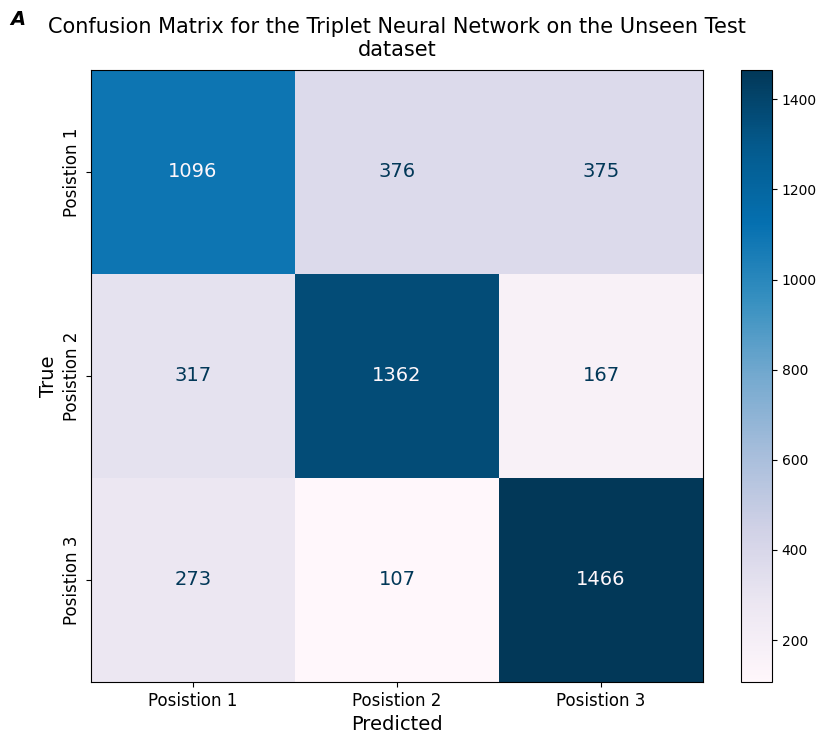

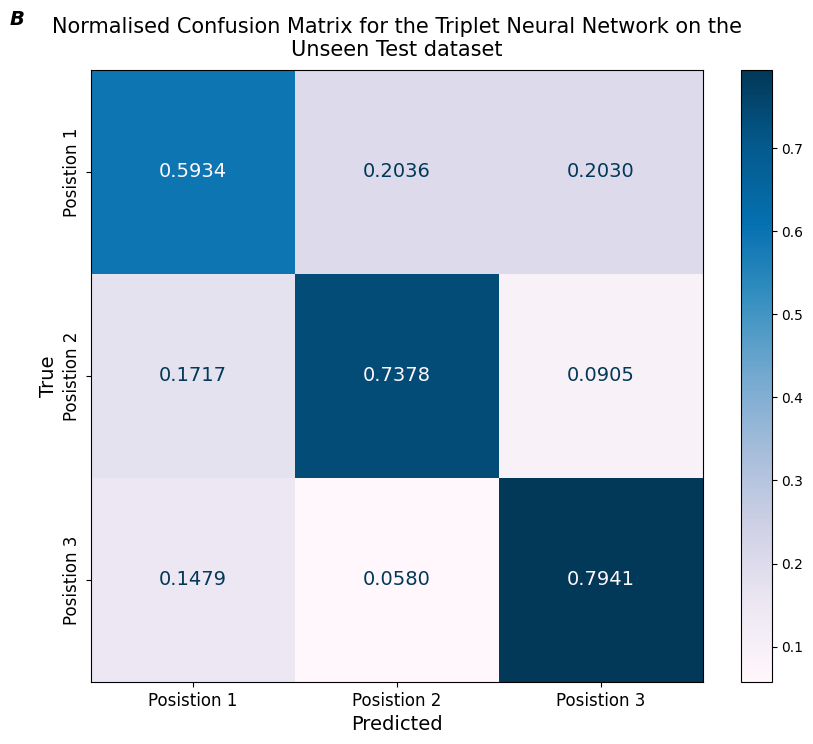

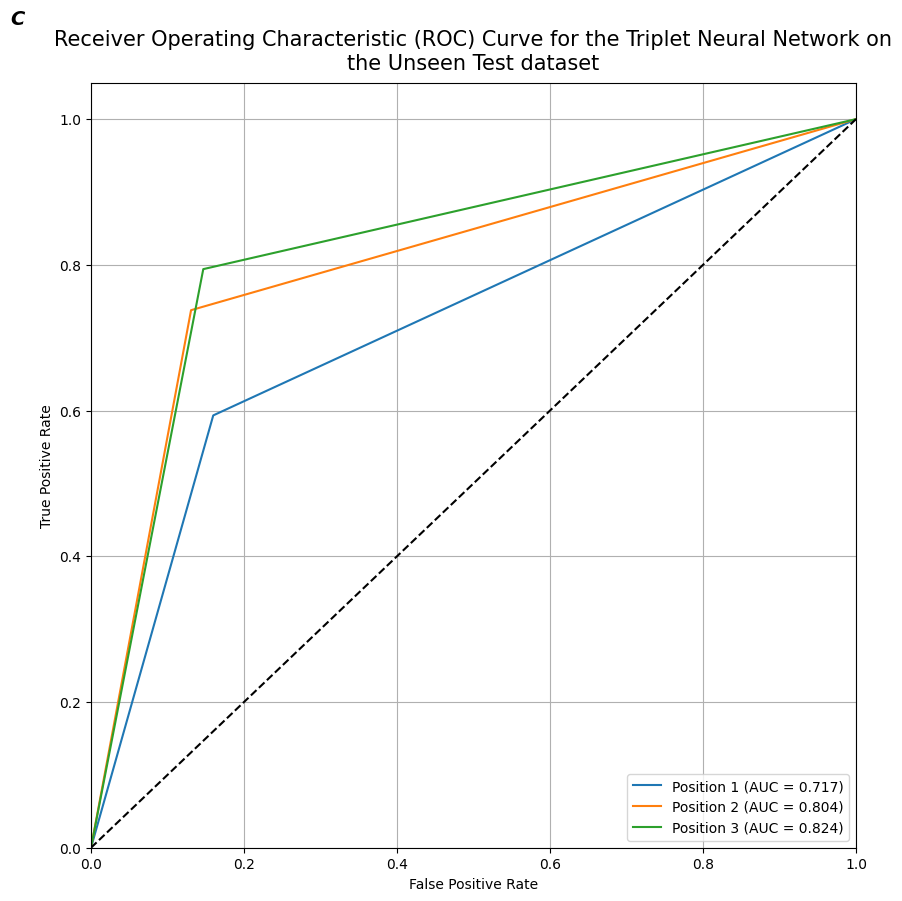

In [25]:
print("Evaluation on unseen test set")
sparsePreds = RDP_NN.predict(x=X_unseen)
# sparsePreds = history.model.predict(x=X_unseen)
y_preds = np.argmax(sparsePreds, axis=1)

print(classification_report(y_true=y_unseen_sparse.numpy(), y_pred=y_preds, digits = 4))

#Confusion Matrix not normalised.
disp, ax = StdConfMatrix(y_unseen_sparse.numpy(), y_preds, figure_number='A')
title = "Confusion Matrix for the Triplet Neural Network on the Unseen Test dataset"
wrapped_title = textwrap.fill(title, width=70)
ax.set_title(wrapped_title, pad=10, size=15) 
ax.set_yticklabels(
                labels=["Posistion 1", "Posistion 2", "Posistion 3"],
                rotation=90,
                va='center',  # Vertical alignment
                ha='center',  # Horizontal alignment
    ) 
ax.set_xticklabels(
                labels=["Posistion 1", "Posistion 2", "Posistion 3"],
                va='center',  # Vertical alignment
                ha='center',  # Horizontal alignment
    )
plt.show()

#Confusion Matrix normalised.
disp, ax = StdConfMatrix(y_unseen_sparse.numpy(), y_preds, normalise='true', format='.4f', figure_number='B')
title = "Normalised Confusion Matrix for the Triplet Neural Network on the Unseen Test dataset"
wrapped_title = textwrap.fill(title, width=70)
ax.set_title(wrapped_title, pad=10, size=15)
ax.set_yticklabels(
                labels=["Posistion 1", "Posistion 2", "Posistion 3"],
                rotation=90,
                va='center',  # Vertical alignment
                ha='center',  # Horizontal alignment
    ) 
ax.set_xticklabels(
                labels=["Posistion 1", "Posistion 2", "Posistion 3"],
                va='center',  # Vertical alignment
                ha='center',  # Horizontal alignment
    )

plt.show()


#ROC Curve
y_preds_onehot = tf.keras.utils.to_categorical(y_preds, num_classes=3)
y_test_onehot = tf.keras.utils.to_categorical(y_unseen_sparse.numpy(), num_classes=3)

plt = plot_roc_curves(y_test_onehot, y_preds_onehot, figure_number='C')
title = "Receiver Operating Characteristic (ROC) Curve for the Triplet Neural Network on the Unseen Test dataset"
wrapped_title = textwrap.fill(title, width=80)
plt.title(wrapped_title, pad=10, size=15) 
plt.savefig('figures/PNN_ROC')
plt.show()

>Attention Method

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

class ReshapeLayer(layers.Layer):
    def __init__(self, target_shape, **kwargs):
        super().__init__(**kwargs)
        self.target_shape = target_shape
    
    def call(self, inputs):
        return tf.keras.layers.Reshape(self.target_shape)(inputs)

class PositionalEncoding(layers.Layer):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        
    def build(self, input_shape):
        position = tf.range(3, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.range(self.d_model, dtype=tf.float32)[tf.newaxis, :]
        angle_rates = 1 / tf.pow(10000.0, (2 * (div_term // 2)) / tf.cast(self.d_model, tf.float32))
        pos_encoding = position * angle_rates
        
        # Apply sin to even indices and cos to odd indices
        sines = tf.sin(pos_encoding[:, 0::2])
        cosines = tf.cos(pos_encoding[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        self.pos_encoding = tf.expand_dims(pos_encoding, 0)
    
    def call(self, inputs):
        return inputs + tf.cast(self.pos_encoding, inputs.dtype)

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, d_model, num_heads, dropout_rate=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % num_heads == 0
        self.depth = d_model // num_heads
        
        self.query_dense = layers.Dense(d_model)
        self.key_dense = layers.Dense(d_model)
        self.value_dense = layers.Dense(d_model)
        
        self.dense = layers.Dense(d_model)
        self.dropout = layers.Dropout(dropout_rate)
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)
    
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]
        
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        scaled_attention_logits = tf.matmul(query, key, transpose_b=True)
        scaled_attention_logits = scaled_attention_logits / tf.math.sqrt(tf.cast(self.depth, tf.float32))
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        attention_weights = self.dropout(attention_weights, training=training)
        
        attention_output = tf.matmul(attention_weights, value)
        attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention_output, (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        output = self.dropout(output, training=training)
        output = self.layer_norm(inputs + output)
        
        return output, attention_weights

class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.attention = MultiHeadSelfAttention(d_model, num_heads, dropout_rate)
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
    
    def call(self, inputs, training=False):
        attention_output, attention_weights = self.attention(inputs, training=training)
        ffn_output = self.ffn(attention_output)
        ffn_output = self.dropout2(ffn_output, training=training)
        output = self.layernorm2(attention_output + ffn_output)
        
        return output, attention_weights

def create_recombinant_transformer(input_shape, num_layers=2, d_model=96, num_heads=4, dff=256, dropout_rate=0.1):
    inputs = layers.Input(shape=input_shape)
    
    # Reshape input into sequence of three 32-feature vectors
    x = ReshapeLayer(target_shape=(3, 32))(inputs)
    
    # Project to d_model dimensions
    x = layers.Dense(d_model)(x)
    
    # Add positional encoding
    x = PositionalEncoding(d_model)(x)
    
    # Transformer blocks
    attention_weights = []
    for _ in range(num_layers):
        x, weights = TransformerBlock(d_model, num_heads, dff, dropout_rate)(x)
        attention_weights.append(weights)
    
    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)
    
    # Final classification
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(3, activation='softmax')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

class AttentionVisualizer(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, log_frequency=5):
        super().__init__()
        self.validation_data = validation_data
        self.log_frequency = log_frequency
        self.attention_history = []
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.log_frequency == 0:
            X_val, _ = self.validation_data
            
            # Get attention weights from intermediate layers
            attention_model = tf.keras.Model(
                inputs=self.model.input,
                outputs=[layer.output[1] for layer in self.model.layers 
                        if isinstance(layer, TransformerBlock)]
            )
            attention_weights = attention_model(X_val)
            
            # Average attention weights across heads and batch
            avg_attention = [tf.reduce_mean(w, axis=[0, 1]).numpy() 
                           for w in attention_weights]
            
            self.attention_history.append({
                'epoch': epoch,
                'attention_weights': avg_attention
            })
            
            print(f"\nEpoch {epoch} - Average attention patterns:")
            for i, layer_weights in enumerate(avg_attention):
                print(f"Layer {i + 1}:")
                print(layer_weights)

def compile_transformer_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=0.0001, beta_1=0.9, beta_2=0.98, epsilon=1e-9
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

> Weight adjusted loss 

In [ ]:
import tensorflow as tf
import numpy as np

class DynamicClassWeightCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, initial_weights=None, adjustment_rate=0.1):
        super().__init__()
        self.X_val, self.y_val = validation_data
        self.adjustment_rate = adjustment_rate
        
        # Initialize weights as a TensorFlow variable
        initial_weights = [1.0, 1.2, 1.0] if initial_weights is None else list(initial_weights.values())
        self.class_weights = tf.Variable(initial_weights, dtype=tf.float32, trainable=False)
        
        self.precision_history = []
        self.recall_history = []
        self.f1_history = []
    
    def calculate_position_metrics(self):
        y_pred = self.model.predict(self.X_val)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_val_np = self.y_val.numpy() if tf.is_tensor(self.y_val) else self.y_val
        
        metrics = {i: {'tp': 0, 'fp': 0, 'fn': 0} for i in range(3)}
        
        for true, pred in zip(y_val_np, y_pred_classes):
            if true == pred:
                metrics[true]['tp'] += 1
            else:
                metrics[pred]['fp'] += 1
                metrics[true]['fn'] += 1
        
        precision = np.zeros(3)
        recall = np.zeros(3)
        f1 = np.zeros(3)
        
        for i in range(3):
            tp = metrics[i]['tp']
            fp = metrics[i]['fp']
            fn = metrics[i]['fn']
            
            precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0
        
        return precision, recall, f1
    
    def on_epoch_end(self, epoch, logs=None):
        precision, recall, f1 = self.calculate_position_metrics()
        
        self.precision_history.append(precision)
        self.recall_history.append(recall)
        self.f1_history.append(f1)
        
        # Update weights using numpy operations
        f1_tensor = np.array(f1, dtype=np.float32)
        mean_f1 = np.mean(f1_tensor)
        performance_ratios = f1_tensor / mean_f1
        adjustments = (1.0 - performance_ratios) * self.adjustment_rate
        new_weights = self.class_weights.numpy() * (1.0 + adjustments)
        normalized_weights = new_weights * 3.0 / np.sum(new_weights)
        
        self.class_weights.assign(normalized_weights)
        
        print(f"\nEpoch {epoch} metrics:")
        print(f"Position-wise F1 scores: {f1}")
        print(f"Updated class weights: {normalized_weights}")

class DynamicWeightedCrossEntropy(tf.keras.losses.Loss):
    def __init__(self, weight_callback, name='dynamic_weighted_crossentropy'):
        super().__init__(name=name)
        self.weight_callback = weight_callback

    def call(self, y_true, y_pred):
        # Get current weights from callback
        weights = self.weight_callback.class_weights
        
        # Convert y_true to integer indices
        y_true = tf.cast(y_true, tf.int32)
        
        # Calculate base sparse categorical crossentropy
        sce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        
        # Apply weights
        sample_weights = tf.gather(weights, y_true)
        
        return sce * sample_weights

def setup_dynamic_weights(model, X_train, y_train, X_val, y_val):
    # Initialize callback
    callback = DynamicClassWeightCallback(
        validation_data=(X_val, y_val),
        initial_weights={0: 1.4, 1: 1.0, 2: 1.0},
        adjustment_rate=0.1
    )
    
    # Create loss function instance
    loss_fn = DynamicWeightedCrossEntropy(callback)
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Lion(learning_rate=1e-4, beta_1=0.96, beta_2=0.99, weight_decay=1e-2),
        loss=loss_fn,
        metrics=['accuracy']
    )
    
    return model, callback